<a href="https://colab.research.google.com/github/samarakoon-ryan/NASANearestEarthObjectsModeling/blob/update-pipeline/project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Predicting Nearest Earth Objects using NASA Dataset




## Background

Outer Space is vast and the number of foreign objects in space is infinite. The distances in space are numbers we cannot fathom, but NASA considers objects within 70,000 Km of Earth as Nearest Earth Objects. These objects or asteroids can be dangerous to Earth and NASA constantly monitors various parameters of these asteroids. Considering the large amount of data available on the current nearest earth objects, it would be useful to use the various parameters of these data to predict whether a nearest earth object is of any concern to Earth.

## Project Description

The NASA Nearest Earth Objects dataset includes over 90,000 datapoints on asteroids. These datapoints include distance, velocity, magnitude, and diameter among other things. All datapoints are also labeled with a boolean value for whether the asteroid is considered hazardous to Earth or not. After some cleaning and feature engineering, I plan to use 10,000 datapoints as a training dataset and another 10,000 datapoints as the test dataset. The test dataset will not include the "hazardous" column as this is what I'll be planning to predict based on the other columns.

Dataset Source - https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects


### Basic Exploratory Data Analysis

1. What is the relationship between hazardousness and relative velocity?
2. What is the relationship between hazardousness and absolute magnitude?
3. What is the distribution of the size of nearest Earth objects?
    - Are there any significant outliers?
4. What is the relationship between relative velocity and absolute magnitude?

In [1]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# load dataset
neos = pd.read_csv("neo.csv")

# display head
neos.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [4]:
# display descriptive statistics for valid columns
neos.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [5]:
# display column info
neos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


[Text(0.5, 1.0, 'Relative Velocity for Hazardousness')]

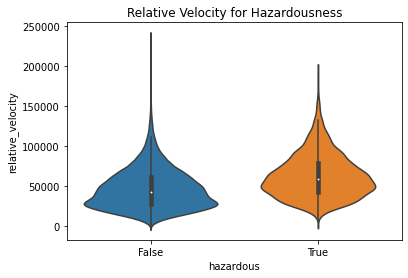

In [6]:
# Violin plots for both hazardous types looking at relative velocity
sns.violinplot(data=neos, y='relative_velocity', x='hazardous').set(title='Relative Velocity for Hazardousness')

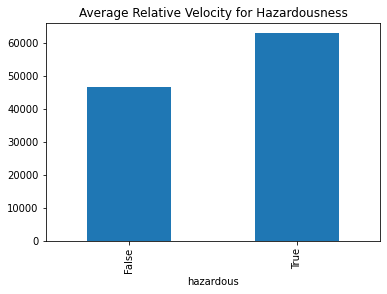

Hazardous NEOs on average had a 35.0% higher relative velocity.


In [7]:
# plot mean relative velocity per hazardousness
neos.groupby('hazardous')['relative_velocity'].mean().plot.bar(title='Average Relative Velocity for Hazardousness')
plt.show()
neos.groupby('hazardous')['relative_velocity'].mean().round(2)
rv_haz = neos.groupby('hazardous')['relative_velocity'].mean()[1].round(2)
rv_non = neos.groupby('hazardous')['relative_velocity'].mean()[0].round(2)

percentage_increase = ((rv_haz - rv_non) / rv_non * 100).round()
print(f'Hazardous NEOs on average had a {percentage_increase}% higher relative velocity.')

hazardous
False    236786.78
True     187478.68
Name: relative_velocity, dtype: float64

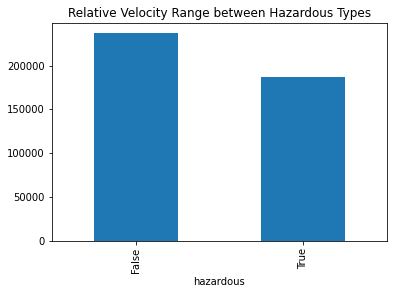

In [8]:
# calculate range for relatively velocity
rv_maximum = neos.groupby('hazardous')['relative_velocity'].max()
rv_minimum = neos.groupby('hazardous')['relative_velocity'].min()
rv_range = rv_maximum - rv_minimum
rv_range.plot.bar(title='Relative Velocity Range between Hazardous Types')
rv_range.round(2)

[Text(0.5, 1.0, 'Absolute Magnitude for Hazardousness')]

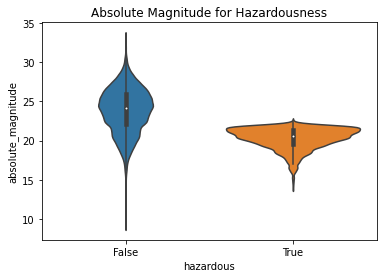

In [9]:
# Violin plots for both hazardous types looking at absolute magnitude
sns.violinplot(data=neos, y='absolute_magnitude', x='hazardous').set(title='Absolute Magnitude for Hazardousness')

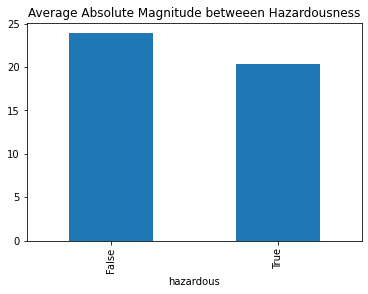

hazardous
False    23.87
True     20.31
Name: absolute_magnitude, dtype: float64

In [10]:
# plot mean absolute magnitude per hazardousness
neos.groupby('hazardous')['absolute_magnitude'].mean().plot.bar(title='Average Absolute Magnitude betweeen Hazardousness')
plt.show()
neos.groupby('hazardous')['absolute_magnitude'].mean().round(2)

hazardous
False    23.97
True      8.36
Name: absolute_magnitude, dtype: float64

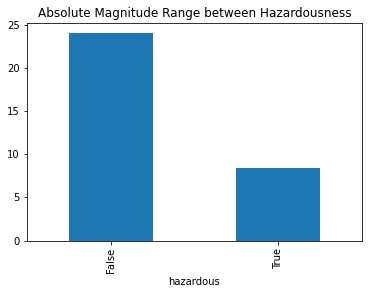

In [11]:
# calculate range for absolute magnitude
absmag_maximum = neos.groupby('hazardous')['absolute_magnitude'].max()
abgmag_minimum = neos.groupby('hazardous')['absolute_magnitude'].min()
absmag_range = absmag_maximum - abgmag_minimum
absmag_range.plot.bar(title='Absolute Magnitude Range between Hazardousness')
absmag_range.round(2)

The estimated minimum diameter on average is 164.0% larger for hazardous NEOs.

The average estimated minimum diameter for hazardous NEOs is 0.29km.
The average estimated minimum diameter for non-hazardous NEOs is 0.11km.

The maximum estimated minimum diameter for hazardous NEOs is 4.14km.
The maximum estimated minimum diameter for non-hazardous NEOs is 37.89km.


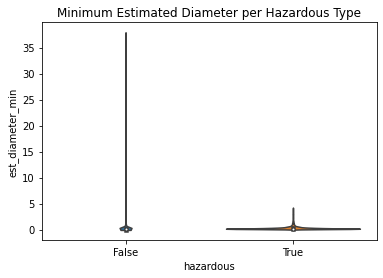

In [12]:
# Visualize distribution of NEO min size
sns.violinplot(data=neos, y='est_diameter_min', x='hazardous').set(title='Minimum Estimated Diameter per Hazardous Type')

haz_min_diam_mean = neos.groupby('hazardous')['est_diameter_min'].mean()[1].round(2)
non_min_diam_mean = neos.groupby('hazardous')['est_diameter_min'].mean()[0].round(2)
percent_change_min_diam_mean = ((haz_min_diam_mean - non_min_diam_mean) / non_min_diam_mean * 100).round()

haz_min_diam_max = neos.groupby('hazardous')['est_diameter_min'].max()[1].round(2)
non_min_diam_max = neos.groupby('hazardous')['est_diameter_min'].max()[0].round(2)

print(f'The estimated minimum diameter on average is {percent_change_min_diam_mean}% larger for hazardous NEOs.\n')
print(f'The average estimated minimum diameter for hazardous NEOs is {haz_min_diam_mean}km.')
print(f'The average estimated minimum diameter for non-hazardous NEOs is {non_min_diam_mean}km.\n')

print(f'The maximum estimated minimum diameter for hazardous NEOs is {haz_min_diam_max}km.')
print(f'The maximum estimated minimum diameter for non-hazardous NEOs is {non_min_diam_max}km.')

The estimated maximum diameter on average is 175.0% larger for hazardous NEOs.

The maximum estimated maximum diameter for hazardous NEOs is 9.25km.
The maximum estimated maximum diameter for non-hazardous NEOs is 84.73km.


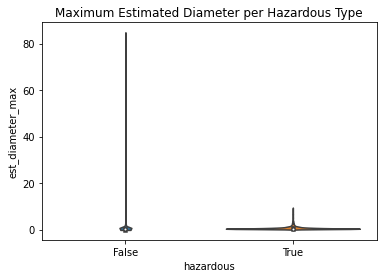

In [13]:
# Visualize distribution of NEO max size
sns.violinplot(data=neos, y='est_diameter_max', x='hazardous').set(title='Maximum Estimated Diameter per Hazardous Type')

haz_max_diam_mean = neos.groupby('hazardous')['est_diameter_max'].mean()[1].round(2)
non_max_diam_mean = neos.groupby('hazardous')['est_diameter_max'].mean()[0].round(2)
percent_change_max_diam_mean = ((haz_max_diam_mean - non_max_diam_mean) / non_max_diam_mean * 100).round()

haz_max_diam_max = neos.groupby('hazardous')['est_diameter_max'].max()[1].round(2)
non_max_diam_max = neos.groupby('hazardous')['est_diameter_max'].max()[0].round(2)

print(f'The estimated maximum diameter on average is {percent_change_max_diam_mean}% larger for hazardous NEOs.\n')


print(f'The maximum estimated maximum diameter for hazardous NEOs is {haz_max_diam_max}km.')
print(f'The maximum estimated maximum diameter for non-hazardous NEOs is {non_max_diam_max}km.')

[Text(0.5, 1.0, 'Absolute Magnitude vs. Relative Velocity')]

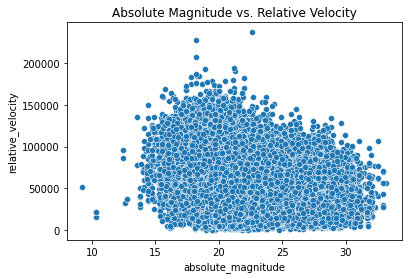

In [14]:
# plot relative velocity and absolute magnitude
sns.scatterplot(x=neos['absolute_magnitude'], y=neos['relative_velocity']).set(title='Absolute Magnitude vs. Relative Velocity')

### Exploratory Analysis Findings
1. It's possible that a higher relative velocity may be an indication of a more hazardous NEO. Although the NEOs not labeled as hazardous had a larger range than the hazardous NEOs, the hazardous NEOs were on average 35% faster in relative velocity than non-hazardous NEOs. 

2. Pertaining to absolute magnitude, the hazardous labeled NEO had a much tighter distribution with most absolute magnitudes lying very close to the mean. The non-hazardous NEOs had a higher absolute magnitude on average but also had a much larger range which could explain the higher average. 

3. Using the estimated minimum diameter, NEOs that are hazardous are on average 164% larger than non-hazardous NEOs. Using the estimated maximum diameter, NEOs that are hazardous are similarly on average 175% larger than non-hazardous NEOs. For both parameters, non-hazardous NEOs had much larger ranges and extremely large outliers. Even though the distribution for hazardous NEOs was much tighter, the average remained higher which is much more compelling.

4. There certainly appears to be a moderate negative correlation between absolute magnitude and relative velocity. As absolute magnitude increases, relative velocity appears to decrease slightly.

### Feature Engineering

- I plan to drop the `orbiting_body` and `sentry_object` columns as they have the same value for each row in both columns respectively.
- I'll also drop `id` as it is a numerical value that the model may think is of relevance, when indeed it is not. All the drops will be performed in the pipeline using "drop" in a `FunctionsTransformer` using `dropper` and `name_dropper`.
- I'd like to take the average of `est_diameter_min` and `est_diameter_max` and put those values into an `est_diameter` column to see whether an average of these columns could provide better modeling. I'll do this by creating a function and then passing it through `FunctionTransformer`. 
- I'd like to try to create a function that extracts the year out of `name` since it's possible that year could have an affect on where NEOs and other planets may be in relation to Earth. I'll do this by creating a couple of functions and then passing it through `FunctionTransformer`. 
- Test values will be applied to the functions doing transformations to confirm it's working properly.

In [76]:
# This function transformer for estimated diameter average

def combine_est_diameter(data_frame):
    """This function finds the average between `est_diameter_min` and `est_diameter_max` to 
    create a new column `est_diameter`. The former two columns are then dropped and the new
    data_frame is returned."""

    data_frame['est_diameter'] = (data_frame['est_diameter_min'] + data_frame['est_diameter_max']) / 2
    data_frame = data_frame.drop(columns=['est_diameter_min', 'est_diameter_max'])
    return data_frame

# test
df = pd.DataFrame(columns=['est_diameter_min', 'est_diameter_max'], data= [[2,4], [1,3]])
combine_est_diameter(df) # should return [[3.0], [2.0]]

,est_diameter
0,3.0
1,2.0


In [77]:
# Function takes in a name_value and finds the year.
# Converts year into integer and returns in.
def find_year(name_value):
    try:
        new_value = ""
        start_idx = name_value.find("(") + 1 
        end_idx = start_idx + 4
        new_value = name_value[start_idx : end_idx]
        new_value = int(new_value)
        return new_value
    except:
        return None

# This is the transformer that converts name to year using the `find_year` function
def year_transformer(data_frame):
    """This transformer applies the `find_year` function to the `name` column
    and then creates a new column `year` with these values. `name` is then dropped
    as well as null values."""
    data_frame['year'] = data_frame['name'].apply(find_year)
    data_frame = data_frame.drop(columns=['name'])

    return data_frame
    
# Example to test find_year()
print(find_year("277475 (2015 WK4)"))  # should return -> 2015
print(type(find_year("277475 (2015 WK4)")))     # should return -> <class 'int'>

# Example to test year_transformer()
df = pd.DataFrame(columns=['name'], data=[["277475 (2015 WK4)"], ["277475 (2000 WK4)"]])
year_transformer(df) # should return [[2015],[2000]]

2015
<class 'int'>


,year
0,2015
1,2000


In [80]:
# This transformer drops `orbiting_body`, `sentry_object`, `id` for the standard pipeline
def dropper(data_frame):
    """This transformer drops `orbiting_body`, `sentry_object`, `id`"""
    data_frame = data_frame.drop(columns=["orbiting_body", "sentry_object", "id"])

    return data_frame

In [81]:
# This transformer drops `name`, `orbiting_body`, `sentry_object`, `id` for the standard pipeline
def name_dropper(data_frame):
    """This transformer is the same as `dropper` and also icludes `name`"""
    data_frame = data_frame.drop(columns=['name', "orbiting_body", "sentry_object", "id"])

    return data_frame

#### Feature Engineering Pipeline
I will construct a pipeline for my feature engineering. This will belong in the beginning of the entire preprocessing pipeline.

In [82]:
# All of the FunctionTransformers are setup here as well as the feature engineering pipeline

est_diameter_transform = FunctionTransformer(combine_est_diameter)
year_pipe_transform = FunctionTransformer(year_transformer)
drop_columns_transform = FunctionTransformer(dropper)
drop_name_transform = FunctionTransformer(name_dropper)

feat_eng = Pipeline([("diameter", est_diameter_transform),
                     ("year", year_pipe_transform),
                     ("dropper", drop_columns_transform)])

#### Model comparison with Feature Engineering

I had already implemented feature engineering prior to this assignment and it wasn't included in my pipeline so I don't have model performance metrics prior to the feature engineering. I decided to create a pipeline without the new feature engineering pipes and one with them for the logistic regression model and compared metrics. Both still contain dropper functions and the pipeline without the feature engineered columns drops the `name` column because it is an overly complicated string that is difficult to categorize. Any corresponding code can be found in any of the following sections labeled Logistic Regression. The summary of my experiment is the following:


*   The `absolute_magnitude` is by far the most important feature in both pipelines.
*   The `est_diameter` engineered feature is slightly more important than the individual `est_diameter_min` and `est_diameter_max`.
*   The newly engineered `year` column seems to have very little importance.
*   Given there wasn't much of a difference between the pipelines, it's no surprise that the precision and recall were essentially the same in both pipelines. 





### Train/Test Split

The dataset contains just over 90,000 datapoints. I will randomly select 40,000 (44%) for training and 40,000 (44%)for testing. I'll then reserve the remaining 10,000+ (12%) for my golden holdout.

In [83]:
# Perform Train/Test split
class_col = 'hazardous'
random_seed = 1234

X_train, X_test, y_train, y_test = train_test_split(neos.drop(columns=class_col), neos[class_col],
                                                   test_size=0.44, train_size= 0.44, random_state=random_seed, stratify=neos[class_col])

In [84]:
# Check dimensions of X
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (39967, 9)


,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude
48136,2446833,446833 (2001 RB12),0.167708,0.375008,35449.205475,6.530534e+07,Earth,False,21.00
58768,3740667,(2016 BU),0.012149,0.027167,30285.492225,5.044515e+07,Earth,False,26.70
1576,2249886,249886 (2001 RY11),0.817627,1.828269,41502.282921,4.218968e+07,Earth,False,17.56
16737,2380929,380929 (2006 HU30),0.321037,0.717860,44153.448899,6.596702e+07,Earth,False,19.59
42924,3644815,(2013 NH10),0.063761,0.142574,44034.483020,5.991513e+07,Earth,False,23.10



On X test: 
X test dimensions:  (39968, 9)


,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude
50018,3799259,(2017 UR52),0.152952,0.342011,194056.414989,4.888464e+07,Earth,False,21.20
83347,3536591,(2010 NG1),0.232571,0.520044,63647.376068,4.830891e+07,Earth,False,20.29
44090,3759719,(2016 SY1),0.011603,0.025944,55686.275337,1.277171e+06,Earth,False,26.80
74407,54016809,(2020 HW7),0.010105,0.022596,27892.028691,7.104528e+07,Earth,False,27.10
80218,54050980,(2020 PB1),0.167708,0.375008,58749.031927,4.584174e+07,Earth,False,21.00


In [86]:
# Check dimensions of Y
# Y Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# Y test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (39967,)


48136    False
58768    False
1576     False
16737    False
42924    False
Name: hazardous, dtype: bool


On y test: 
y test dimensions:  (39968,)


50018    False
83347    False
44090    False
74407    False
80218     True
Name: hazardous, dtype: bool

### Pipeline

Considering my data have no missing values, I won't need any imputation pipelines. Since my only non-numerical column will be a binary column value there will be no use for one hot encoding. However, a few features had some extreme outliers so I will consider using a scaler such as `RobustScaler` or `StandardScaler` to normalize the data. The problem I'm solving is a binary classification problem, so I will first implement with a Logistic Regression classification model.

In [87]:
# Build pipe for handling numerical and categorical data

num_pipeline = Pipeline(steps=[('scale_num', StandardScaler()),
                               ('num_impute', SimpleImputer(missing_values=np.nan, strategy='mean'))])

cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

In [88]:
# Establish preprocessing pipe via column transformer

preproc = ColumnTransformer([('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number)),
                             ('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object))],
                             remainder='passthrough')

preproc_feat = ColumnTransformer([('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number)),
                             ('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object))],
                             remainder='passthrough')

#### Logistic Regression Pipeline

In [89]:
# Generate pipeline for logistic regression model without feature engineering pipes
logistic_regression_pipe = Pipeline(steps=[
                       ('Dropper', drop_name_transform),
                       ('PreProcessing', preproc),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

# visualization of the pipeline
with config_context(display='diagram'):
    display(logistic_regression_pipe)

Pipeline(steps=[('Dropper',
                 FunctionTransformer(func=<function name_dropper at 0x7fc7ab387e60>)),
                ('PreProcessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale_num',
                                                                   StandardScaler()),
                                                                  ('num_impute',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7ab41c390>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7ab41cb90>)])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

In [90]:
# Generate pipeline for logistic regression model including feature engineering pipes
logistic_regression_feat_pipe = Pipeline(steps=[
                       ('FeatureEngineering', feat_eng),
                       ('PreProcessing', preproc),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

# visualization of the pipeline
with config_context(display='diagram'):
    display(logistic_regression_feat_pipe)

Pipeline(steps=[('FeatureEngineering',
                 Pipeline(steps=[('diameter',
                                  FunctionTransformer(func=<function combine_est_diameter at 0x7fc7ab4ddb90>)),
                                 ('year',
                                  FunctionTransformer(func=<function year_transformer at 0x7fc7ab3cd710>)),
                                 ('dropper',
                                  FunctionTransformer(func=<function dropper at 0x7fc7ab387ef0>))])),
                ('PreProcessing',
                 ColumnTransformer(remainder='passthrough...
                                                                  ('num_impute',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7ab41c390>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7ab41cb90>)])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

#### Support Vector Machines Pipeline

In [ ]:
# Generate pipeline for supper vector model
support_vector_pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', SVC(gamma='auto'))])

# visualization of the pipeline
with config_context(display='diagram'):
    display(support_vector_pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f19dd8a96d0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f19dd8a9710>)])),
                ('mdl', SVC(gamma='auto'))])

#### K-Nearest Neighbors Pipeline

In [ ]:
# Generate pipeline for supper vector model
knn_pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', KNeighborsClassifier())])

# visualization of the pipeline
with config_context(display='diagram'):
    display(knn_pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f19dd8a96d0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f19dd8a9710>)])),
                ('mdl', KNeighborsClassifier())])

### Model Fitting and Evaluation

Since I'm looking to see if an NEO is hazardous, this will be a binary classification problem. I have one primary assumption for feature importance:
- `miss_distance` will most likely be the most important feature considering that we can assume that the closer an NEO is to Earth, the more potential dangerous it is.

I anticipate the model to perform well (90%+) since there are some general trends with all of the numerical features. 

#### Logistic Regression Fit & Evaluation

In [91]:
# Setup Tuning Grid & Grid Search for Logistic Regression with and without Feature Engineering

logistic_regression_tuning_grid = {'mdl__l1_ratio': np.linspace(0,1,5),
                                   'mdl__C': np.logspace(-1,6,3)}

logistic_regression_grid_search = GridSearchCV(logistic_regression_pipe, param_grid=logistic_regression_tuning_grid, return_train_score=True, n_jobs=-1)
logistic_regression_feat_grid_search = GridSearchCV(logistic_regression_feat_pipe, param_grid=logistic_regression_tuning_grid, return_train_score=True, n_jobs=-1)

In [92]:
# Find best logistic regression model parameters by fitting grid search
logistic_regression_grid_search.fit(X_train, y_train)

# Find best logistic regression feature engineered model parameters by fitting grid search
logistic_regression_feat_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('FeatureEngineering',
                                        Pipeline(steps=[('diameter',
                                                         FunctionTransformer(func=<function combine_est_diameter at 0x7fc7ab4ddb90>)),
                                                        ('year',
                                                         FunctionTransformer(func=<function year_transformer at 0x7fc7ab3cd710>)),
                                                        ('dropper',
                                                         FunctionTransformer(func=<function dropper at 0x7fc7ab387ef0>))])),
                                       ('PreProcessing',
                                        ColumnTransformer...
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         <sklearn.compose._co

In [94]:
# logistic regression best model parameteres and values
print(logistic_regression_grid_search.best_score_)
print(logistic_regression_grid_search.best_params_)

# logistic regression feature engineered best model parameteres and values
print(logistic_regression_feat_grid_search.best_score_)
print(logistic_regression_feat_grid_search.best_params_)

0.9018440297131394
{'mdl__C': 0.1, 'mdl__l1_ratio': 1.0}
0.9016939296490383
{'mdl__C': 0.1, 'mdl__l1_ratio': 0.25}


In [ ]:
# logistic regression best estimator pipeline
logistic_regression_grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f19dd8a9c10>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f19dd8953d0>)])),
                ('mdl',
                 LogisticRegression(C=1000000.0, l1_ratio=0.25,
                                    penalty='elasticnet', solver=

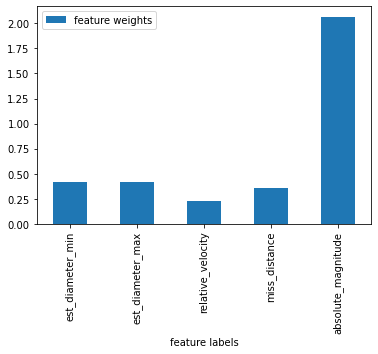

In [98]:
# logistic regression feature weights
lr_feature_weight = abs(logistic_regression_grid_search.best_estimator_['mdl'].coef_[0])
lr_feature_names = ['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']

lr_feature_importance = pd.DataFrame({'feature labels': lr_feature_names, 'feature weights': lr_feature_weight})
lr_feature_importance.plot.bar(x='feature labels', y='feature weights')
plt.show()

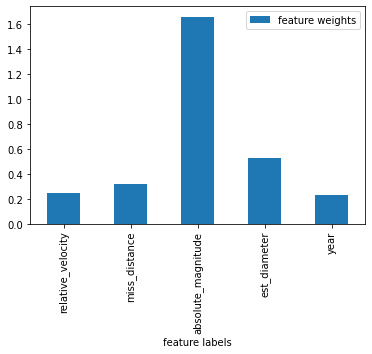

In [96]:
# logistic regression feature engineered feature weights
lr_feature_weight = abs(logistic_regression_feat_grid_search.best_estimator_['mdl'].coef_[0])
lr_feature_names = ['relative_velocity', 'miss_distance', 'absolute_magnitude', 'est_diameter', 'year']

lr_feature_importance = pd.DataFrame({'feature labels': lr_feature_names, 'feature weights': lr_feature_weight})
lr_feature_importance.plot.bar(x='feature labels', y='feature weights')
plt.show()

#### Support Vector Machines Fit & Evaluation

In [ ]:
# Setup Tuning Grid & Grid Search for Support Vector Machines Model

support_vector_tuning_grid = {'mdl__C': [0.1,1],
                              'mdl__kernel': ['linear', 'poly', 'rbf']}

support_vector_grid_search = GridSearchCV(support_vector_pipe, param_grid=support_vector_tuning_grid, return_train_score=True)

In [ ]:
# Find best support vector model parameters by fitting grid search
support_vector_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale_num',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f19dd8a96d0>),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         <sklearn.com

In [ ]:
# Support Vector machines best model parameteres and values
print(support_vector_grid_search.best_score_)
support_vector_grid_search.best_params_

0.9102464656574503


{'mdl__C': 1, 'mdl__kernel': 'rbf'}

In [ ]:
# Support Vector machines best estimator pipeline
support_vector_grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f19dd8a9f90>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f19e2524b50>)])),
                ('mdl', SVC(C=1, gamma='auto'))])

#### K-Nearest Neighbors Fit & Evaluation

In [ ]:
# Setup Tuning Grid & Grid Search for K-Nearest Neighbors Model
knn_tuning_grid = {'mdl__n_neighbors': [1,5, 10],
                    'mdl__leaf_size': [10, 20, 30],
                    'mdl__p': [1,2],
                    'mdl__weights': ['uniform', 'distance']}

knn_grid_search = GridSearchCV(knn_pipe, param_grid=knn_tuning_grid, return_train_score=True)

In [ ]:
# Find best k-nearest neighbors model parameters by fitting grid search
knn_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale_num',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f19dd8a96d0>),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         <sklearn.com

In [ ]:
# K-Nearest Neighbors best model parameteres and values
print(knn_grid_search.best_score_)
knn_grid_search.best_params_

0.912948830226448


{'mdl__leaf_size': 10,
 'mdl__n_neighbors': 10,
 'mdl__p': 1,
 'mdl__weights': 'distance'}

In [ ]:
# K-Nearest Neighbors best estimator pipeline
knn_grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f19dd856410>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f19dd603510>)])),
                ('mdl',
                 KNeighborsClassifier(leaf_size=10, n_neighbors=10, p=1,
                                      weights='distance'

## Performance Metrics

Given I have an extremely unbalanced dataset, I will assume that it will be difficult to accurately predict `true` values. Recall will be an importance metric to look at as the false negative result is very costly in this scenario. Precision and f1-score will also be looked at but won't be as important. I expect logistic regression to perform the worst but have no insight yet on which model will perform better between support vector machines and k-nearest neighbors.

### Logistic Regression Performance Metrics

In [99]:
# Logistic Regression Classification Report
print(classification_report(y_test, logistic_regression_grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

       False       0.91      1.00      0.95     36079
        True       0.46      0.03      0.06      3889

    accuracy                           0.90     39968
   macro avg       0.68      0.51      0.50     39968
weighted avg       0.86      0.90      0.86     39968



In [100]:
# Logistic Regression Feature Engineered Classification Report
print(classification_report(y_test, logistic_regression_feat_grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

       False       0.90      1.00      0.95     36079
        True       0.39      0.03      0.05      3889

    accuracy                           0.90     39968
   macro avg       0.65      0.51      0.50     39968
weighted avg       0.85      0.90      0.86     39968



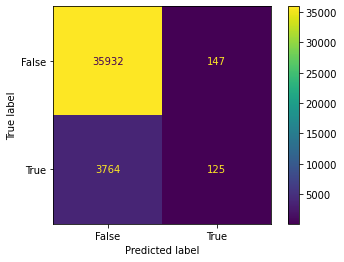

In [101]:
# Logistic Regression Confusion Matrix
lr_cm = confusion_matrix(y_test, logistic_regression_grid_search.best_estimator_.predict(X_test))
lr_disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm,
                                    display_labels=logistic_regression_grid_search.classes_)
lr_disp.plot()
plt.show()

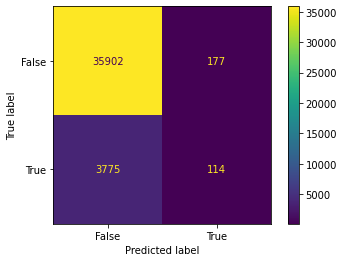

In [102]:
# Logistic Regression Feature Engineered Confusion Matrix
lr_cm = confusion_matrix(y_test, logistic_regression_feat_grid_search.best_estimator_.predict(X_test))
lr_disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm,
                                    display_labels=logistic_regression_feat_grid_search.classes_)
lr_disp.plot()
plt.show()

### Support Vector Machines Performance Metrics

In [ ]:
# Support Vector Machines Classification Report
print(classification_report(y_test, support_vector_grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

       False       0.91      1.00      0.95     36077
        True       0.78      0.11      0.19      3889

    accuracy                           0.91     39966
   macro avg       0.85      0.55      0.57     39966
weighted avg       0.90      0.91      0.88     39966



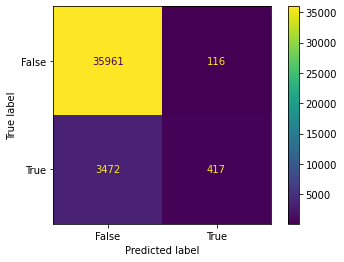

In [ ]:
# Support Vector Machines Confusion Matrix
svm_cm = confusion_matrix(y_test, support_vector_grid_search.best_estimator_.predict(X_test))
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm,
                                    display_labels=support_vector_grid_search.classes_)
svm_disp.plot()
plt.show()

### K-Nearest Neighbors Performance Metrics

In [ ]:
# K-Nearest Neighbors Classification Report
print(classification_report(y_test, knn_grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

       False       0.93      0.98      0.95     36077
        True       0.58      0.32      0.42      3889

    accuracy                           0.91     39966
   macro avg       0.76      0.65      0.68     39966
weighted avg       0.90      0.91      0.90     39966



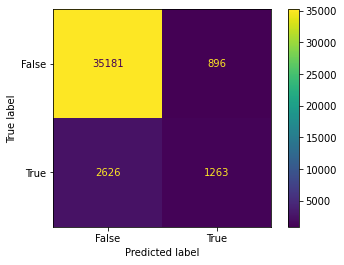

In [ ]:
# K-Nearest Neighbors Confusion Matrix
knn_cm = confusion_matrix(y_test, knn_grid_search.best_estimator_.predict(X_test))
knn_disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm,
                                    display_labels=knn_grid_search.classes_)
knn_disp.plot()
plt.show()

### Summary of Preliminary Modeling Results

3 different models were fitted and tuned using Grid Search for hyperparameter tuning. It was very clear from the beginning that the data were extremely unbalanced and this was quickly proven by disproportionately lower performance metrics for the `true` labeled result.  All models performed well in predicting whether a datapoint was a non-hazardous asteroid (`false`) with precision, recall, and f1 scores being all 0.90 or higher. 



Therefore the best performing model should be the one which did the best with predicting hazardous asteroids (`true`). The support vector machines model provided the highest precision by far for `true` results at 0.78 but had a very poor recall at 0.11 giving it an f1 score of 0.19. The k-nearest neighbors model had a precision of 0.58 and a recall of 0.32 giving it an f1 score of 0.42. The logistic regression model had low performance metrics across the board and won't be considered going foward. 



Since logistic regression assumes some sort of linearity this may have been the downfall of the model as it's not entirely certain if there are any linear relationships in this dataset. Support vector machines perform well with highly dimensional datasets and can also deal with unbalanced datasets with the `weights` parameter which was tuned during the grid search. K-nearest neighbors0 classifiers can also deal with unbalanced datasets in a similar way which could be a reason why it also performed better than the logistic regression model among other reasons. 



In this scenario I believe that recall is the most important metric because the false negative instance (predicting an asteroid to be non-hazardous and its true value is hazardous) is the most costly by far so we would want recall to be as high as possible. Given this I predict that the K-Nearest Neighbors model is most likely the best performing model when it comes to business value.

    

#### Comparing models using business metrics

    

In [ ]:
# Logistic Regression Business Costs

lr_true_non = 10
lr_false_non = 10 + (5*(lr_cm[0][1]))
lr_false_haz = 10 + (100*(lr_cm[1][0]))
lr_true_haz = 10 + (5*(lr_cm[1][1]))

lr_total_cost = (lr_true_non + lr_false_non + lr_false_haz + lr_true_haz) // 1000

print(f'The total business cost using a logistic regression model is ${lr_total_cost} B')

The total business cost using a logistic regression model is $378 B


In [ ]:
# Support Vector Machines Business Costs

svm_true_non = 10
svm_false_non = 10 + (5*(svm_cm[0][1]))
svm_false_haz = 10 + (100*(svm_cm[1][0]))
svm_true_haz = 10 + (5*(svm_cm[1][1]))

svm_total_cost = (svm_true_non + svm_false_non + svm_false_haz + svm_true_haz) // 1000

print(f'The total business cost using a support vector machines model is ${svm_total_cost} B')

The total business cost using a support vector machines model is $349 B


In [ ]:
# K-Nearest Neighbors Business Costs

knn_true_non = 10
knn_false_non = 10 + (5*(knn_cm[0][1]))
knn_false_haz = 10 + (100*(knn_cm[1][0]))
knn_true_haz = 10 + (5*(knn_cm[1][1]))

knn_total_cost = (knn_true_non + knn_false_non + knn_false_haz + knn_true_haz) // 1000

print(f'The total business cost using a k-nearest neighbors model is ${knn_total_cost} B')

The total business cost using a k-nearest neighbors model is $273 B


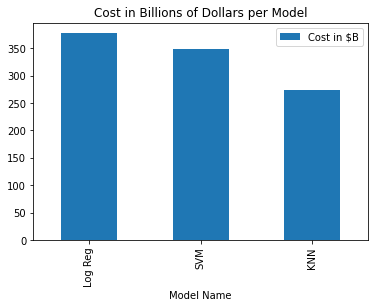

In [ ]:
model_comp_names = ['Log Reg', 'SVM', 'KNN']
model_costs = [lr_total_cost, svm_total_cost, knn_total_cost]

model_comp = pd.DataFrame({'Model Name': model_comp_names, 'Cost in $B': model_costs})
model_comp.plot.bar(x='Model Name', y='Cost in $B', title='Cost in Billions of Dollars per Model')
plt.show()

Using the formulas in the README.md file I calculated business costs for all scenarios in the confusion matrix for each model. As predicted the K-Nearest Neighbors model had the lowest business cost. It was \$76 B cheaper than the Support Vector Machines model and it was over \$100 B cheaper than the Logistic Regression model.